# Rad-IA: tratamiento de datos y metodologia de funcionamiento
Para los medicos, una IA que ayude a detectar diferentes enfermedades y fracturas usando radiografias es muy util, dado que acorta el tiempo de diagnostico y permite una ejecucion de un tratamiento mas rapida, para poder ayudar a esto, es necesario comprender algunos conceptos y metodos que se van a usar para facilitar y mejorar el funcionamiento de esta herramienta.

Primero, es importante saber que el cuerpo humano cuenta con 206 huesos, para poder clasificar de mejor manera la region de la radiografia a analizar es necesario segmentar el cuerpo humano en 2 secciones muy importantes, el tronco central, y las extremidades.

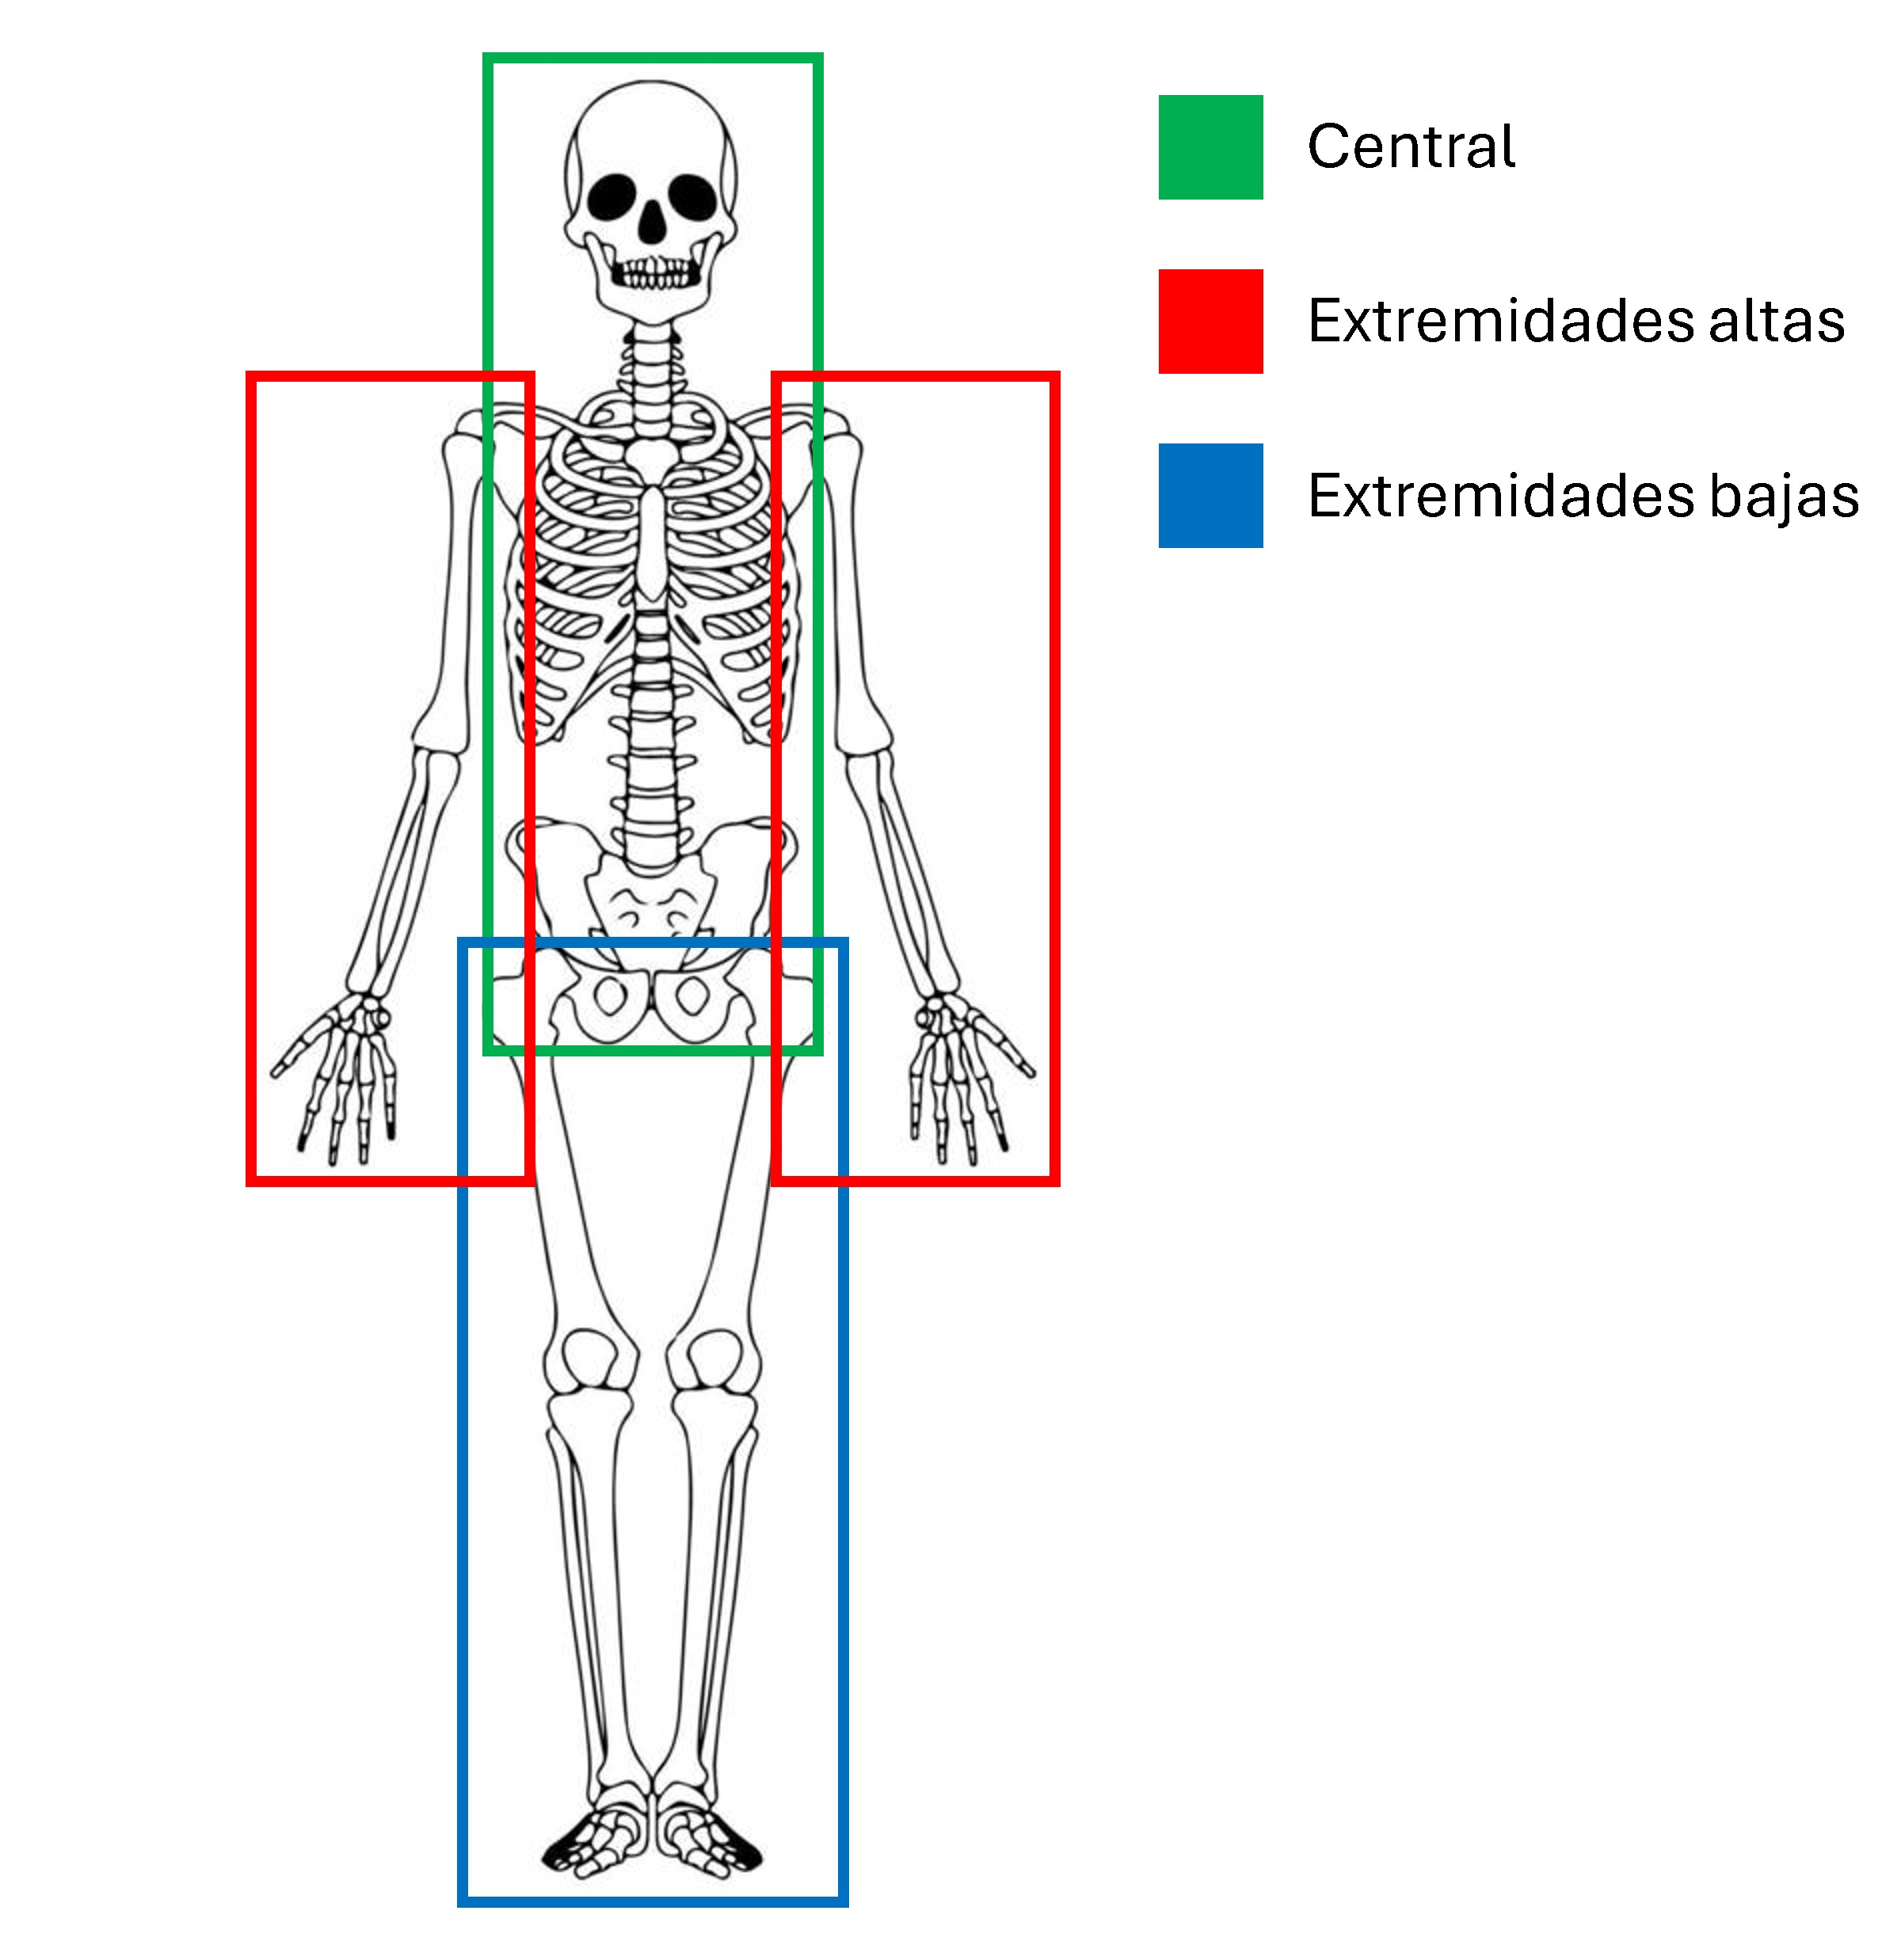

para seccionar estas areas y ser mas especifico, es posible segmentar cada una de estas en areas mas reducidas.

Para el caso del tronco central, es posible dividirlo en [Cabeza, Pecho, Pelvis].

Para el caso de las extremidades altas, es posible dividirlas en [Hombro, Codo,Mano].

Para el caso de las extremidades bajas, es posible dividirlas en [Femur, Rodilla, Perone, Pie]

Por lo que, el primer paso, es cargar la informacion con sus respectivas clasificaciones

In [ ]:
!pip install tensorflow
!pip install keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import numpy as np

# Cargar modelos
main_model = load_model("/content/drive/My Drive/Main.keras")
central_model = load_model("/content/drive/My Drive/Central.keras")
alta_model = load_model("/content/drive/My Drive/Alta.keras")
baja_model = load_model("/content/drive/My Drive/Baja.keras")
altas_fracture_model = load_model("/content/drive/My Drive/AltasFracture.keras")
bajas_fracture_model = load_model("/content/drive/My Drive/BajasFracture.keras")
hip_fracture_model = load_model("/content/drive/My Drive/HipFracture.keras")
chest_disease_model = load_model("/content/drive/My Drive/ChestDisease.keras")
print("Modelos cargados correctamente.")

In [ ]:
# Clases
main_classes = ["Tronco central", "Extremidades altas", "Extremidades bajas"]
central_classes = ["Cráneo", "Pecho", "Pelvis"]
alta_classes = ["Hombro", "Codo", "Mano"]
baja_classes = ["Coxis-Femoral", "Rodilla", "Pie"]
fracture_classes = ["Normal", "Fractura", "Objeto externo"]
chest_classes = [
    "Absceso", "ARDS", "Atelectasia", "Aterosclerosis de la aorta",
    "Cardiomegalia", "Enfisema", "Fractura", "Hidroneumotórax",
    "Hidrotórax", "Neumonía", "Neumoesclerosis", "Cambios postinflamatorios",
    "Deformación postraumática de costillas", "Sarcoidosis", "Escoliosis",
    "Tuberculosis", "Congestión venosa", "Normal"
]


In [ ]:
def preprocess_image(image_path):
    # Cargar imagen en escala de grises
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Redimensionar
    img = cv2.resize(img, (320, 320))
    # Normalización (0-1)
    img = img / 255.0
    # Invertir si el fondo es más claro que el objeto
    if np.mean(img) > 0.5:
        img = 1 - img
    # Aplicar CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    img = clahe.apply((img * 255).astype(np.uint8)) / 255.0
    # Corrección gamma (ajusta el brillo de la imagen)
    gamma = 0.8  # Ajusta este valor según la calidad de las imágenes
    img = np.power(img, gamma)

    return img

In [ ]:
def preprocess_image_HD(image_path):
    # Cargar imagen en escala de grises
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Redimensionar
    img = cv2.resize(img, (1024, 1024))
    # Normalización (0-1)
    img = img / 255.0
    # Invertir si el fondo es más claro que el objeto
    if np.mean(img) > 0.5:
        img = 1 - img
    # Aplicar CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    img = clahe.apply((img * 255).astype(np.uint8)) / 255.0
    # Corrección gamma (ajusta el brillo de la imagen)
    gamma = 0.8  # Ajusta este valor según la calidad de las imágenes
    img = np.power(img, gamma)

    return img

In [ ]:
# Función de predicción con severidad continua
def predict_with_severity(model, img, class_labels):
    predictions = model.predict(img)  # Se asume que devuelve dos salidas
    class_pred = np.argmax(predictions[0])  # Categoría principal
    severity_pred = float(predictions[1][0])  # Severidad como valor continuo
    return class_labels[class_pred], severity_pred

In [ ]:
# Predicción
# Ruta de prueba
image_path = "/content/drive/My Drive/imagen_prueba.jpg"
img = preprocess_image(image_path)
imgHD = preprocess_image_HD(image_path)
# Main.keras
main_pred = main_model.predict(img)
main_class = np.argmax(main_pred)
main_label = main_classes[main_class]
print(f"Primera clasificación: {main_label}")

In [ ]:
if main_label == "Tronco central":
    sub_label, _ = predict_with_severity(central_model, img, central_classes)
    print(f"Sub-clasificación: {sub_label}")

    if sub_label == "Pecho":
        disease_label, severity = predict_with_severity(chest_disease_model, imgHD, chest_classes)
        print(f"Diagnóstico torácico: {disease_label} | Severidad: {severity:.2f}")
    else:
        fracture_label, severity = predict_with_severity(hip_fracture_model, imgHD, fracture_classes)
        print(f"Diagnóstico de fractura: {fracture_label} | Severidad: {severity:.2f}")

elif main_label == "Extremidades altas":
    sub_label, _ = predict_with_severity(alta_model, img, alta_classes)
    print(f"Sub-clasificación: {sub_label}")

    fracture_label, severity = predict_with_severity(altas_fracture_model, imgHD, fracture_classes)
    print(f"Diagnóstico de fractura: {fracture_label} | Severidad: {severity:.2f}")

elif main_label == "Extremidades bajas":
    sub_label, _ = predict_with_severity(baja_model, img, baja_classes)
    print(f"Sub-clasificación: {sub_label}")
    fracture_label, severity = predict_with_severity(bajas_fracture_model, imgHD, fracture_classes)
    print(f"Diagnóstico de fractura: {fracture_label} | Severidad: {severity:.2f}")

# **Mostrar imagen con el resultado**
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()